2018_8월_근로형태별_20250826_42207.csv
2019_8월_근로형태별_20250825_87431.csv
2021_8월_근로형태별_20250827_41497.csv
2022_8월_근로형태별_20250827_41497.csv
2023_8월_근로형태별_20250826_22167.csv
경제활동인구조사_8월_근로형태별(제공)_2024.csv
총6개의 파일을 찾았습니다

가장 최근 조사인 2024년 데이터에 227개의 칼럼이 있습니다.

제외할 칼럼은 ['_LABEL']. 105개의 칼럼이 제거되었습니다.
122개의 칼럼을 조사합니다.

2018_8월_근로형태별_20250826_42207.csv에 ['현재업무시작전근무경험여부', '연령계층코드', '사업시작시애로사항코드', '현재일시작연월']의 데이타가 없습니다.NaN으로 채웁니다.
2019_8월_근로형태별_20250825_87431.csv에 ['현재업무시작전근무경험여부', '사업시작시애로사항코드', '현재일시작연월']의 데이타가 없습니다.NaN으로 채웁니다.
2021_8월_근로형태별_20250827_41497.csv에 ['현재업무시작전근무경험여부', '사업시작시애로사항코드', '현재일시작연월']의 데이타가 없습니다.NaN으로 채웁니다.
2022_8월_근로형태별_20250827_41497.csv에 ['현재업무시작전근무경험여부', '사업시작시애로사항코드', '현재일시작연월']의 데이타가 없습니다.NaN으로 채웁니다.
2023_8월_근로형태별_20250826_22167.csv에 []의 데이타가 없습니다.NaN으로 채웁니다.
경제활동인구조사_8월_근로형태별(제공)_2024.csv에 []의 데이타가 없습니다.NaN으로 채웁니다.

총 데이터는 122개의 열, 353077개의 행입니다.

['현재일관련사항_10차산업대분류코드', '이전직장_1자리_10차산업대분류코드']은 숫자 코드로 변환합니다.

['현재일관련사항_직장시작연월', '최근3개월간평균급여']에서 0이 될 수 없는 샘플을 삭제합니다.

199604개의 

 98%|===================| 10536/10743 [00:18<00:00]       

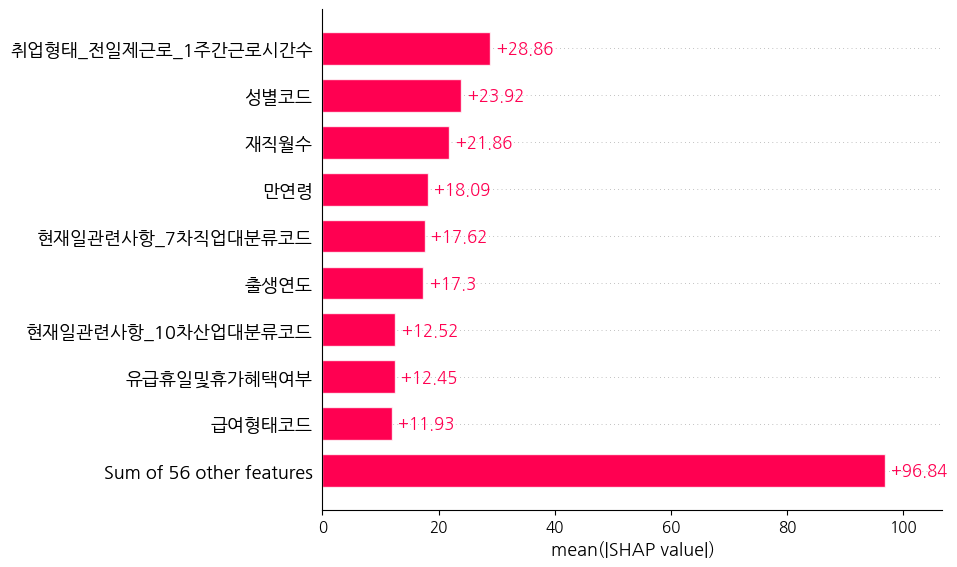

--- XGBoost 모델 분석 완료 ---


In [66]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import warnings
from sklearn.metrics import mean_squared_error
import os
import re
import glob


#폴더에서 csv 전체를 읽고, 기준 데이터에서 피처를 선정

def read_csv_and_select_feature(folder_path, drop_col, str_col, del_if_zero):
    
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    if not csv_files:
        print ("csv 파일을 찾을 수 없습니다.")
    else:
        for file in csv_files:
            print(f"{os.path.basename(file)}")
        print(f"총{len(csv_files)}개의 파일을 찾았습니다\n")

    # 파일명을 통해 가장 최근 데이터를 선정하고 그 파일의 칼럼을 통합할 데이터의 기준으로
    most_recent_file = None
    max_year=0
    year_pattern = re.compile(r'\d{4}')
    
    for file in csv_files:
        file_name = os.path.basename(file)
        match = year_pattern.search(file_name)
        if match:
            current_year= int(match.group())
            if current_year > max_year:
                max_year = current_year
                most_recent_file= file

    try: 
        benchmark_col = pd.read_csv(most_recent_file, encoding="cp949", nrows=0)
    except UnicodeDecodeError:
        benchmark_col = pd.read_csv(most_recent_file, encoding="uft-8", nrows=0)
    print (f"가장 최근 조사인 {max_year}년 데이터에 {len(benchmark_col.columns)}개의 칼럼이 있습니다.\n")
    
    # drop_col에 있는 제외할 칼럼을 제거. 
    all_col = benchmark_col.columns.tolist()
    filtered_col = [col for col in all_col if not any(re.search(keyword, col) for keyword in drop_col)]
    print(f"제외할 칼럼은 {drop_col}. {len(all_col)-len(filtered_col)}개의 칼럼이 제거되었습니다.\n{len(filtered_col)}개의 칼럼을 조사합니다.\n")

    #선택된 피쳐(열)가 있는 칼럼을 파일에서 읽은 후 데이타를 병합.
    df_list=[]
    warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
    
    for file in csv_files:
        
        try: 
            df_col=pd.read_csv(file, encoding="cp949", nrows=0).columns
            csv_encoding="cp949"
        except UnicodeDecodeError:
            df_col=pd.read_csv(file, encoding="utf-8", nrows=0).columns
            csv_encoding="uft-8"
    
        col_to_load= list(set(filtered_col) & set(df_col))
        if col_to_load != filtered_col:
            print(f"{os.path.basename(file)}에 {list(set(filtered_col) - set(df_col))}의 데이타가 없습니다.NaN으로 채웁니다.")
        df= pd.read_csv(file, encoding=csv_encoding, usecols=col_to_load)
        df=df.reindex(columns=filtered_col)
        
        df=df[1:]
        df_list.append(df)
    
    merged_df=pd.concat(df_list, ignore_index=True)
    print(f"\n총 데이터는 {len(merged_df.columns)}개의 열, {len(merged_df)}개의 행입니다.\n")

    #str_col은 문자 코드. 숫자 코드로 변환
    print(f"{str_col}은 숫자 코드로 변환합니다.\n")
    all_col=merged_df.columns.tolist()
    numberic_col = list(set(all_col) - set(str_col))
    for col in numberic_col:
        merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
    le=LabelEncoder()
    for col in str_col:
        merged_df[col]=le.fit_transform(merged_df[col])
    
     #모델에 중요한 영향을 미치기 때문에 0이 되면 안 되는 피쳐 del_if_zero에서 값이 0인 샘플을 삭제
    print(f"{del_if_zero}에서 0이 될 수 없는 샘플을 삭제합니다.\n")
    len_before=len(merged_df)
    for col in del_if_zero:
        merged_df=merged_df[merged_df[col]>0]
    len_after =len(merged_df)
    print(f"{len_before - len_after}개의 샘플을 제거했습니다.\n")
    
    return merged_df


#_____________________________________________________________________
#0을 평균으로 대체, 0이 과반 이상이면 삭제

def zero_processing(df):
        
    df_temp=df.replace(0, np.nan)
    df_mean=df_temp.mean().round()
    df_semifinal=df_temp.fillna(df_mean)
    df_final=df_semifinal.fillna(0).astype(int)
    print("0을 평균값으로 대체. 열의 값이 모두 NaN인 경우 0으로 대체")
    
    #0이 과반 이상인 열을 삭제
    zeros_count = (df_final == 0).sum()
    columns_to_drop = zeros_count[zeros_count > (len(df_final) / 2)].index.tolist()
    print(f"\n0의 값이 절반을 초과하는 열: {columns_to_drop}을 삭제.\n")
    df_final = df_final.drop(columns=columns_to_drop)
    print(f"최종 {len(df_final.columns)+1}개의 피쳐를 조사합니다.")
    return df_final


#_____________________________________________________________________
#입사연월과 조사연월을 이용해 근속 계산 
def len_of_serv_calculator(df, enterance_date_col_name,census_date_col_name):

    enterance_date_col=[]
    census_date_col=[]
    len_of_service=[]
    enterance_date_col = pd.to_datetime(df[enterance_date_col_name].astype(str), format='%Y%m')
    census_date_col = pd.to_datetime(df[census_date_col_name].astype(str), format="%Y%m")
    
    len_of_service=(census_date_col.dt.year - enterance_date_col.dt.year)*12 +(census_date_col.dt.month - enterance_date_col.dt.month)
    df_len_of_service = pd.Series(len_of_service, name="재직월수")
    
    df=pd.concat([df, df_len_of_service], axis=1)
    df=df.drop(columns=[enterance_date_col_name,census_date_col_name])
    print (f"{enterance_date_col_name}과 {census_date_col_name}을 이용해 [재직월수] 칼럼을 만들었습니다.")
    return df


#_____________________________________________________________________
#XGboost 머신러닝

def XGboost_ML(df, target_col, weight_col, n_estimators=30):
    
    X = df.drop([target_col, weight_col], axis=1)
    y= df[target_col]
    w= df[weight_col]
    
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.3, random_state=42)
    
    model= xgb.XGBRegressor(objective="reg:squarederror", n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train, sample_weight=w_train)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred, sample_weight=w_test))
    mean = y_test.mean()
    print("-" * 30)
    print(f"\nXGBoost 모델 성능 (RMSE): {rmse:.2f} \n 타깃 평균은 {mean:.2f}.\n 평균 대비 RMSE는 {rmse/mean:.2%}")
    print("-" * 30)
    print("\nXGBoost 모델의 SHAP 플롯을 생성합니다.\n")
    X_train_10= X_train.sample(frac=0.1, random_state=1)
    explainer = shap.Explainer(model, X_train)
    s_values= explainer(X_train_10)
    shap.plots.bar(s_values, max_display=10)
   
    print("--- XGBoost 모델 분석 완료 ---")
    return s_values

def main():
    
    # 중요 파라미터들
    folder_path="data" #csv 파일이 있는 폴더
    drop_col = ["_LABEL"] #변수 설명하는 칼럼들
    str_col = ['현재일관련사항_10차산업대분류코드', '이전직장_1자리_10차산업대분류코드'] #분류코드가 String인 칼럼
    del_if_zero =["현재일관련사항_직장시작연월", "최근3개월간평균급여" ] #값이 0인 경우 삭제해야 하는 샘플
    enterance_date_col="현재일관련사항_직장시작연월"
    census_date_col ="조사연월"
    weight_col = "가중값"
    target_col="최근3개월간평균급여"
    
    #함수 호출
    df= read_csv_and_select_feature(folder_path=folder_path, drop_col=drop_col, str_col=str_col, del_if_zero=del_if_zero)
    df= zero_processing(df=df)
    df= len_of_serv_calculator(df=df, enterance_date_col_name=enterance_date_col, census_date_col_name=census_date_col )
    shap_values= XGboost_ML(df=df, target_col=target_col, weight_col=weight_col, n_estimators=30)

if __name__ == "__main__":
    main()
